# OCR Agent from scratch:

* Data
    * Find public data available online
    * Build doc-index
* [Utilities](./Data-Processing.ipynb)
* [Extract layout features and visual tokens](./Data-Extraction-2.ipynb)
* [Generate training data](./Data-Extraction-3.ipynb)
* [Model architecture](./Model-Backbone.ipynb)
* [Traversal strategies](./Traversal-Layout.ipynb)
* [Reader Agent](./Agent-LM.ipynb)
* [Leverage synthetic training data](./Data-Gen.ipynb)
* [Optimization for production](./Optimization.ipynb)


### Project data sources
As an example workload we used tax-forms: the problem stated as visual layout understanding enabling high-precision data extraction from the multi-page scanned documents (set of page-images) with complex taxonomy, and sensitive user data which must be properly protected.

The forms are publicly available for download from gov. web-sites. We gathered a set of about 2000 forms in English and French languages from IRS and Canada Revenue Agency. It's a small set of blank forms lacking variety of styles. (Good enough for POC project, not sufficient for the foundation agent training.)

We do not have any real scanned forms -- for this POC starter we can easily synthesize those from the blanks.
Blanks are useful even if we have the real data -- for pre-training and identification pipeline setup.

![Doc Indexing Pipeline](./assets/doc-indexing-pipeline.svg)


### Initial batch-Indexing
Our starter ingestion pipeline (batch-indexing) uses `BeautifulSoup` and `PyMuPDF`:
* Scrape the target sites
* Extract text and layout data from the `pdf` and convert pages to images
* Extract `taxonomy-markers` (doc-identifiers) and index them for fast identification
* Encode the titles and semantically-sound text-blocks and store in a vector database to enable `semantic search`
* Extract the `data-schemas` (list of form input with types and labels) and cache them for the fast retrieval by the form-identifier

        data/
         ├── forms/     --- original PDF-docs downloaded from www
         ├── images/    --- images of the doc-pages extracted from PDF
         ├── content/   --- text and layout information extracted from PDF
         ├── inputs/    --- interactive widgets information extracted from interactive PDF
         └── ...


### Storage solutions

<img src="./assets/elasticsearch.png"
     style="display:inline;float:left;vertical-aligh:middle;margin-right:15px"/>

#### Word / Pattern / Spatial search: [`ElasticSearch`]()
In this project we need the way to search for exact and fuzzy (OCR misses) match with spacial awareness: match alpha-numeric patterns (taxonomy markers, form-inputs labels) appearing in specific locations.

<br clear="both"/>

<img src="./assets/qdrant.png"
     style="display:inline;float:left;vertical-aligh:middle;margin-right:15px"/>
     
#### Semantic search and similar images search: [`Qdrant`]()
We vectorize doc titles and semantically sound text-blocks using open-source LM.
We vectorize logos and symbols helping to identify the doc using our own visual encoder (agent view).
Vector database is needed for the agent RAG as well.

<br clear="both"/>

## 


In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image, ImageOps
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import patches

In [2]:
# local R&D libs
from scripts.parse import *
from scripts.extract import *
from scripts.search import *

In [3]:
#target DPI
DPI

300

In [4]:
# forms scraped from IRS and Canada Revenue Agency
forms = [str(x)[len('data/forms/'):-len('.pdf')] for x in Path('./data/forms').glob('*.pdf')]
len(forms)

2858

#### 1. Parse PDF and save data in files for analysis
We used python `fitz` to parse data, the same package we used to simulate filed forms.

In [5]:
#!python scrips/parse.py

    !rm ./data/images/*
    !rm ./data/content/*
    !rm ./data/inputs/*

    info = []
    for i, name in enumerate(forms, 1):
        num_pages, num_inputs = extract_pages(name, DPI)
        info.append((name, num_pages, num_inputs))
        print(f'done: {i/len(forms):.2%}', end='\r')
    
    pd.DataFrame(info, columns=['source','num-pages','num-inputs'])\
      .to_csv('./data/doc-summary.csv.gz', index=False, compression='gzip')

In [6]:
# total samples (pages)
pd.read_csv('./data/doc-summary.csv.gz').set_index('source')['num-pages'].sum()

8633

In [7]:
# page-images
samples = [str(x)[len('data/images/'):-len('.png')] for x in Path('./data/images').glob('*.png')]
len(samples)

8633

cnd-t1223.en-0


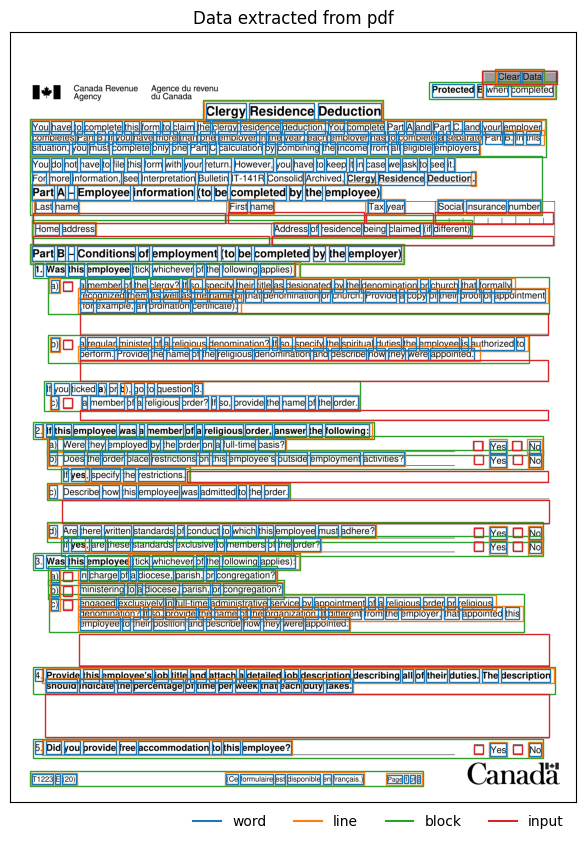

In [8]:
    # pick random page and display image with bboxes colored by type
    source = np.random.choice(samples)
    print(source)
    
    # load data
    image = ImageOps.grayscale(Image.open(f'./data/images/{source}.png'))
    blocks = pd.read_csv(f'./data/content/{source}.csv.gz')
    inputs = pd.read_csv(f'./data/inputs/{source}.csv.gz')

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, 'gray')
    obj = ['word','line','block','input']
    for i, label in enumerate(obj):
        ax.plot([0], [0], color=f'C{i}',label=label)
    # text
    for l, t, r, b, s, q in blocks[['left','top','right','bottom','scale','block-type']].values:
        w, h = (r - l) * s, (b - t) * s
        x, y = l * s, t * s
        i = obj.index(q)
        ax.add_patch(patches.Rectangle((x - i * 5, y - i * 5), w + i * 10, h + i * 10,
                                       linewidth=1, edgecolor=f'C{i}', facecolor='none'))
    # inputs
    for l, t, r, b in inputs[['left','top','right','bottom']].values:
        w, h = (r - l) * s, (b - t) * s
        x, y = l * s, t * s
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='C3', facecolor='none'))    
    ax.set_title(f'Data extracted from pdf')
    ax.legend(bbox_to_anchor=(1, 0), ncol=4, frameon=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

This pdf-dataset insufficient on its own for making reliable labels for anything but plain text extraction. Text may appear as a part of the background image, as well as form outlines, in that case they won't appear in data.

The presence of taxonomy markers in the header/footer simplifies identification, however, it is still a significant challenge for OCR due to taxonomy markers being alpha-numeric patterns: more sensitive to misses vs. the plain text we can spell-correct.

#### 2. Cleanup, transform, and load to databases
Our permanent storage solution should support a short phrase or alpha-numeric sequence search with `levenshtein` distance for taxonomy identification, backed up by semantic search on titles and short contents, and spacial search for the input label or the next textual block. We also need a `scratchpad` solution for the agent to store some working progress (embeddings).

In [9]:
search = InputSearch()
search.get_docs('W2')['buckets']

[{'key': 'irs-fw2c', 'doc_count': 512},
 {'key': 'irs-fw2', 'doc_count': 272},
 {'key': 'irs-fw2_21', 'doc_count': 230},
 {'key': 'irs-fw2g', 'doc_count': 159},
 {'key': 'irs-fw2as_21', 'doc_count': 158},
 {'key': 'irs-fw2gu_21', 'doc_count': 158},
 {'key': 'irs-fw2vi_21', 'doc_count': 158},
 {'key': 'irs-fw2as', 'doc_count': 126},
 {'key': 'irs-fw2gu', 'doc_count': 126},
 {'key': 'irs-fw2vi', 'doc_count': 126}]

In [10]:
search.find_inputs('irs-fw2c', input_type='CheckBox')[0]

{'_index': 'doc-pages',
 '_id': 'IRS-FW2C-1-I4',
 '_score': None,
 '_source': {'content': 'CheckBox NAME: p2-cb1 LABEL: ',
  'block_type': 'input',
  'font_size': 5,
  'display': '0',
  'page_id': 1,
  'doc_id': 'irs-fw2c',
  'taxonomy_id': 'W2',
  'orig': 0,
  'lang': 'en',
  'left': 0.9183,
  'top': 0.1944,
  'right': 0.9314,
  'bottom': 0.2092},
 'sort': ['1', 0.1944, 0.9183]}

In [11]:
search = SemanticSearch()
search.find('taxes related to children')

[{'ext': '',
  'lang': 'en',
  'orig': 0,
  'taxonomy': '8615',
  'text': 'Tax for Certain Children Who Have Unearned Income'},
 {'ext': 'EN',
  'lang': 'fr',
  'orig': 2,
  'taxonomy': 'IM30',
  'text': "Entente entre exploitants associés relative à l'impôt minier"},
 {'ext': 'V',
  'lang': 'en',
  'orig': 2,
  'taxonomy': 'IN103',
  'text': 'Refundable Tax Credit for Childcare Expenses'},
 {'ext': '',
  'lang': 'fr',
  'orig': 2,
  'taxonomy': 'IN103',
  'text': "Le crédit d'impôt remboursable pour frais de garde d'enfants"},
 {'ext': '29.E',
  'lang': 'fr',
  'orig': 2,
  'taxonomy': 'CO1175',
  'text': 'Entente relative à la taxe sur les services publics'}]